<a href="https://colab.research.google.com/github/btian/deep-learning/blob/main/rl_policy_gradient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import base64, io, time, gym
import IPython, functools
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

!pip install mitdeeplearning
import mitdeeplearning as mdl

     |████████████████████████████████| 2.1MB 5.9MB/s 
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.2.0-cp37-none-any.whl size=2115442 sha256=20d6daaa23949abfdfb01f85c28349027855e309544bb490d9b446d55f8d4a15
  Stored in directory: /root/.cache/pip/wheels/af/dc/2a/5c3633135e7e4ef4fd31463cfa1942cb1bae7486ab94e7a2ad
Successfully built mitdeeplearning


In [ ]:
env = gym.make('CartPole-v0')
env.seed(1)

[1]

In [ ]:
n_observations = env.observation_space
print("Environment has observation space =", n_observations)

Environment has observation space = Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


In [ ]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 2


In [ ]:
def create_cartpole_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(units=32, activation='relu'),
      tf.keras.layers.Dense(n_actions)
  ])
  return model

cartpole_model = create_cartpole_model()

In [ ]:
def choose_action(model, observation, single=True):
  observation = np.expand_dims(observation, axis=0) if single else observation
  logits = model.predict(observation)
  action = tf.random.categorical(logits, num_samples=1)
  action = action.numpy().flatten()
  return action[0] if single else action

In [ ]:
class Memory:
  def __init__(self):
    self.clear()

  def clear(self):
    self.observations = []
    self.actions = []
    self.rewards = []

  def add_to_memory(self, new_observation, new_action, new_reward):
    self.observations.append(new_observation)
    self.actions.append(new_action)
    self.rewards.append(new_reward)


# Combine a list of Memory objects into a single memory.
def aggregate_memories(memories):
  batch_memory = Memory()
  for memory in memories:
    for step in zip(memory.observations, memory.actions, memory.rewards):
      batch_memory.add_to_memory(*step)
  return batch_memory


memory = Memory()

In [ ]:
def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x.astype(np.float32)


def discount_rewards(rewards, gamma=0.95):
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(len(rewards))):
    R = R * gamma + rewards[t]
    discounted_rewards[t] = R
  return normalize(discounted_rewards)

In [ ]:
def compute_loss(logits, actions, rewards):
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(
      labels=actions, logits=logits)
  loss = tf.reduce_mean(neg_logprob * rewards)
  return loss


In [ ]:
def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
    logits = model(observations)
    loss = compute_loss(logits, actions, discounted_rewards)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

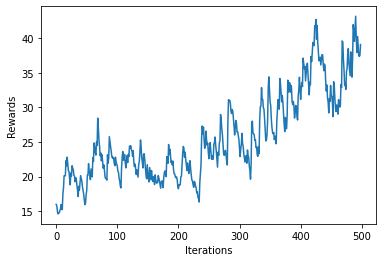

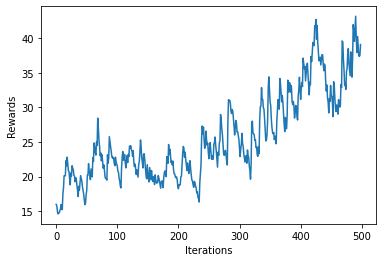

In [ ]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

cartpole_model = create_cartpole_model()

smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

if hasattr(tqdm, '_instances'): tqdm._instances.clear()
for episode in range(500):
  plotter.plot(smoothed_reward.get())
  observation = env.reset()
  memory.clear()
  while True:
    action = choose_action(cartpole_model, observation)
    next_observation, reward, done, info = env.step(action)
    memory.add_to_memory(observation, action, reward)
    if done:
      total_reward = sum(memory.rewards)
      smoothed_reward.append(total_reward)
      discounted_rewards = discount_rewards(memory.rewards)
      train_step(cartpole_model, optimizer, 
                 observations=np.vstack(memory.observations),
                 actions=np.array(memory.actions),
                 discounted_rewards=discounted_rewards)
      memory.clear()
      break
    observation = next_observation

In [ ]:
!nvidia-smi

Mon Mar 22 05:47:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    31W /  70W |    382MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
saved_cartpole = mdl.lab3.save_video_of_model(cartpole_model, "CartPole-v0")
mdl.lab3.play_video(saved_cartpole)

Successfully saved 200 frames into CartPole-v0.mp4!


In [ ]:
# Pong
def create_pong_env():
  return gym.make('Pong-v0', frameskip=5)


env = create_pong_env()
env.seed(1)

[1, 289714752]

In [ ]:
print("Environment has observation space =", env.observation_space)

Environment has observation space = Box(0, 255, (210, 160, 3), uint8)


In [ ]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 6


In [ ]:
def create_pong_model():
  Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
  Flatten = tf.keras.layers.Flatten
  Dense = tf.keras.layers.Dense
  model = tf.keras.models.Sequential([
      Conv2D(filters=32, kernel_size=5, strides=2),
      Conv2D(filters=48, kernel_size=5, strides=2),
      Conv2D(filters=64, kernel_size=3, strides=2),
      Flatten(),
      Dense(units=128, activation='relu'),
      Dense(units=n_actions)
  ])
  return model

pong_model = create_pong_model()

In [ ]:
def discount_rewards(rewards, gamma=0.99):
  # Reward at the end is either 1 (win) or -1 (lose).
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(len(rewards))):
    # Reset the sum if the reward is not 0 (the game has ended!)
    if rewards[t] != 0:
      R = 0
    R = R * gamma + rewards[t]
    discounted_rewards[t] = R
  return normalize(discounted_rewards)

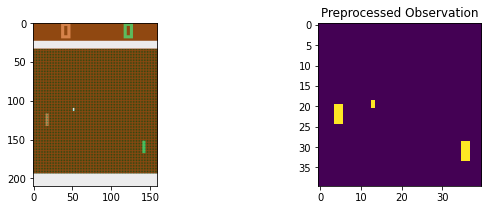

In [ ]:
observation = env.reset()
for i in range(30):
  action = np.random.choice(n_actions)
  observation, _,_,_ = env.step(action)
observation_pp = mdl.lab3.preprocess_pong(observation)

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(observation); ax.grid(False);
ax2.imshow(np.squeeze(observation_pp)); ax2.grid(False); plt.title('Preprocessed Observation');

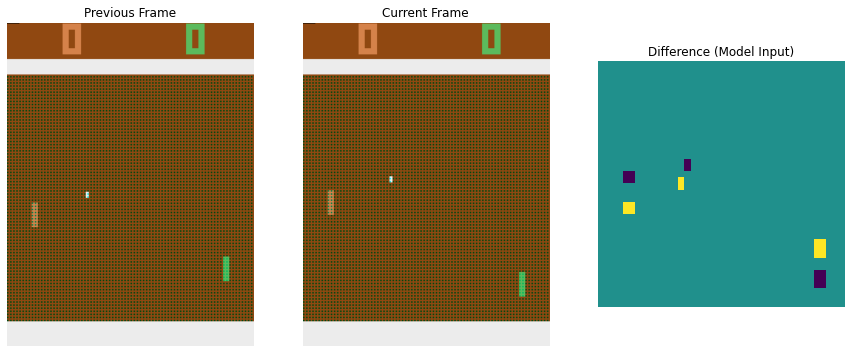

In [ ]:
next_observation, _,_,_ = env.step(np.random.choice(n_actions))
diff = mdl.lab3.pong_change(observation, next_observation)

f, ax = plt.subplots(1, 3, figsize=(15,15))
for a in ax:
  a.grid(False)
  a.axis("off")
ax[0].imshow(observation); ax[0].set_title('Previous Frame');
ax[1].imshow(next_observation); ax[1].set_title('Current Frame');
ax[2].imshow(np.squeeze(diff)); ax[2].set_title('Difference (Model Input)');

In [ ]:
def collect_rollout(batch_size, env, model, choose_action):
  memories = []
  for b in range(batch_size):
    memory = Memory()
    next_observation = env.reset()
    previous_frame = next_observation
    done = False

    while not done:
      current_frame = next_observation
      frame_diff = mdl.lab3.pong_change(previous_frame, current_frame)
      action = choose_action(model, frame_diff)
      next_observation, reward, done, info = env.step(action)
      memory.add_to_memory(frame_diff, action, reward)
      previous_frame = current_frame
    
    memories.append(memory)
  return memories

In [ ]:
### Rollout with untrained Pong model ###

# Model
test_model = create_pong_model()

# Rollout with single batch
single_batch_size = 1
memories = collect_rollout(single_batch_size, env, test_model, choose_action)
rollout_video = mdl.lab3.save_video_of_memory(memories[0], "Pong-Random-Agent.mp4")

# Play back video of memories
mdl.lab3.play_video(rollout_video)

In [ ]:
learning_rate = 1e-3
MAX_ITERS = 1000
batch_size = 5

pong_model = create_pong_model()
optimizer = tf.keras.optimizers.Adam(learning_rate)
iteration = 0

smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
smoothed_reward.append(0)
plotter = mdl.util.PeriodicPlotter(sec=15, xlabel='Iterations', ylabel='Win Percentage (%)')

envs = [create_pong_env() for _ in range(batch_size)]

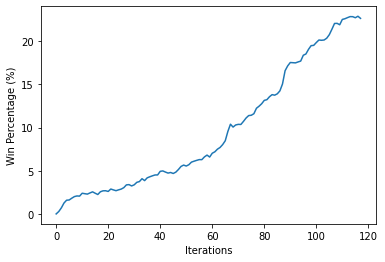

In [ ]:
### Training Pong ###
# You can run this cell and stop it anytime in the middle of training to save 
#   a progress video (see next codeblock). To continue training, simply run this 
#   cell again, your model will pick up right where it left off. To reset training,
#   you need to run the cell above. 

games_to_win_episode = 21 # this is set by OpenAI gym and cannot be changed.

# Main training loop
while iteration < MAX_ITERS:

  plotter.plot(smoothed_reward.get())

  tic = time.time()
  # RL agent algorithm. By default, uses serial batch processing.
  # memories = collect_rollout(batch_size, env, pong_model, choose_action)

  # Parallelized version. Uncomment line below (and comment out line above) to parallelize
  memories = mdl.lab3.parallelized_collect_rollout(batch_size, envs, pong_model, choose_action)
  print(time.time()-tic)

  # Aggregate memories from multiple batches
  batch_memory = aggregate_memories(memories)

  # Track performance based on win percentage (calculated from rewards)
  total_wins = sum(np.array(batch_memory.rewards) == 1)
  total_games = sum(np.abs(np.array(batch_memory.rewards)))
  win_rate = total_wins / total_games
  smoothed_reward.append(100 * win_rate)
  
  # Training!
  train_step(
      pong_model,
      optimizer,
      observations = np.stack(batch_memory.observations, 0),
      actions = np.array(batch_memory.actions),
      discounted_rewards = discount_rewards(batch_memory.rewards)
  )

  # Save a video of progress -- this can be played back later
  if iteration % 100 == 0:
    mdl.lab3.save_video_of_model(pong_model, "Pong-v0", 
                                                suffix="_"+str(iteration))
    
  iteration += 1 # Mark next episode

In [ ]:
latest_pong = mdl.lab3.save_video_of_model(
    pong_model, "Pong-v0", suffix="_latest")
mdl.lab3.play_video(latest_pong, width=400)